In [1]:
import networkx as nx
import os, sys
import matplotlib.pyplot as plt
import random
import pandas as pd
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import simulation

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np

# Load data
datapath = "artifacts/"
df = pd.read_csv(f"{datapath}/story_list.csv")
df

# First, ensure that the 'Published_time' is in datetime format
df['Published_time'] = pd.to_datetime(df['Published_time'], format='%d-%b-%y')

# Find the earliest date, which will be our reference point
reference_date = df['Published_time'].min()

# Calculate the difference in days from the reference date
df['Release_daily'] = (df['Published_time'] - reference_date).dt.days

# Calculate the difference in weeks from the reference date
# The difference in days is divided by 7 and then we use np.floor to get the full weeks.
# astype(int) is used to convert the result into an integer
df['Release_weekly'] = np.floor((df['Published_time'] - reference_date).dt.days / 7).astype(int)

In [3]:
# Get list of a release time (daily)
data_list = df[['Item', 'Release_daily']].values.tolist()
print(data_list)

[[1, 224], [2, 200], [3, 198], [4, 0], [5, 2], [6, 4], [7, 18], [8, 182], [9, 186], [10, 184], [11, 183], [12, 197], [13, 200], [14, 189], [15, 185], [16, 200], [17, 201], [18, 236], [19, 243], [20, 303]]


In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def create_custom_graph():
    # Create an empty graph
    G = nx.Graph()
    
    # Add 20 nodes. Assuming nodes are labeled from 0 to 21 (story 0 as dummy)
    G.add_nodes_from(range(1,21))
    
    # Manually add edges. Each tuple represents a link between two nodes.
    edges = [(1,2), (2,3), (3,4), (4,5), (5,6), (5, 7), (5, 8),
             (7,8), (8,9), (8,10), (8,11), (8,12), (9,13), (10,12), (10,15),
             (11,14), (12,13), (12, 16), (16,17), (16,18), (18,19), (19,20)]
    
    # Add edges to the graph
    G.add_edges_from(edges)
    
    return G

# Create the graph
story_G = create_custom_graph()

# Draw the graph
# plt.figure(figsize=(8, 8))
# nx.draw(G, with_labels=True, node_size=700, node_color="lightblue", font_weight="bold")
# plt.show()

In [5]:
def small_world_graph(n):
    G = nx.watts_strogatz_graph(n=n, k=4, p=0.2)
    return G

# Create the graph
social_G = small_world_graph(200)

# Draw the graph
# plt.figure(figsize=(8, 8))
# nx.draw(social_G, with_labels=True, node_size=700, node_color="lightblue", font_weight="bold")
# plt.show()

In [6]:
import pickle 
import os
def read_file(path):
    with open(f"./data/{path}/results.pkl","rb") as f:
        data = pickle.load(f)
    np_data = np.array([tuple(d.values()) for d in data])
    df = pd.DataFrame(np_data,columns = list(data[0].keys()))
    df['adopted'] = df['adopted'].astype(int) 
    return df

In [7]:
import importlib
import agent
importlib.reload(agent)
importlib.reload(simulation)

<module 'simulation' from '/Users/jeintron/Dropbox/@PROJECTS/BLF/CONSTRUCT/STORY_SIM/simulation.py'>

Running 10 trials.
..........

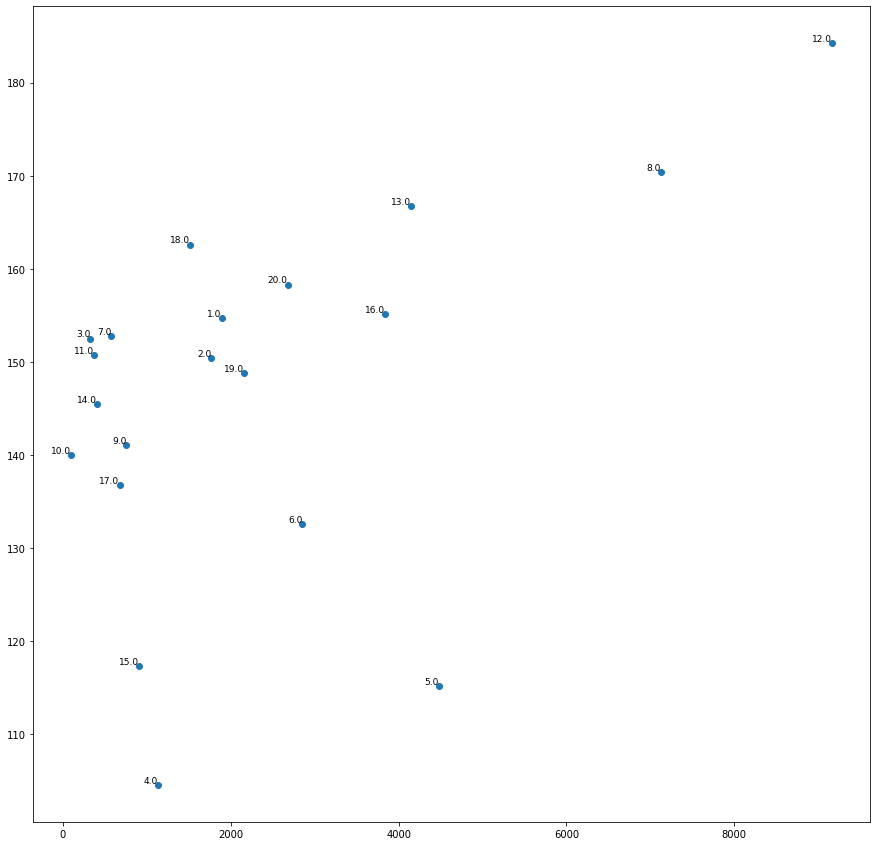

array([[1.        , 0.49469242],
       [0.49469242, 1.        ]])

In [8]:
social_G = nx.watts_strogatz_graph(n=200, k=6, p=0.2)

# best = params = {"filestub":"trump_test_1","alpha":.7,"beta":1,"max_item_relevance":14,"x_0":5, "gamma":.4}

params = {"filestub":"ci24_test_1","alpha":.3,"beta":1,"max_item_relevance":14,"x_0":5, "gamma":.6, "phi":2.5}

sim = simulation.Simulation(story_graph=story_G,params=params,social_graph=social_G,config_path="../config/simulation.properties")
sim.run(10)

search_directory = "./data"

# Get a list of all items in the directory
items = os.listdir(search_directory)

# Filter out files, leaving only directories
directories = [item for item in items if os.path.isdir(os.path.join(search_directory, item))]

# Sort the directories by their creation time (newest first)
directories.sort(key=lambda x: os.path.getctime(os.path.join(search_directory, x)), reverse=True)

# Get the name of the most recently created directory
most_recent_directory = directories[0] if directories else None

most_recent_directory

data = read_file(most_recent_directory)
last = data[data.timestep == 349]
summary = last.groupby(["Trial","story_item"])["adopted"].sum().reset_index()
final = summary.groupby(['story_item'])['adopted'].mean().reset_index()
merged = df.merge(final,left_on="Item",right_on="story_item")
x = merged.Shares.to_list()
y = merged.adopted.to_list()
plt.figure(figsize=[15,15])
plt.scatter(x,y)

for i, label in enumerate(merged.story_item.to_list()):
    plt.text(x[i],y[i],f"{label}",fontsize=9,ha='right',va='bottom')

plt.show()
np.corrcoef(x,y)
#data

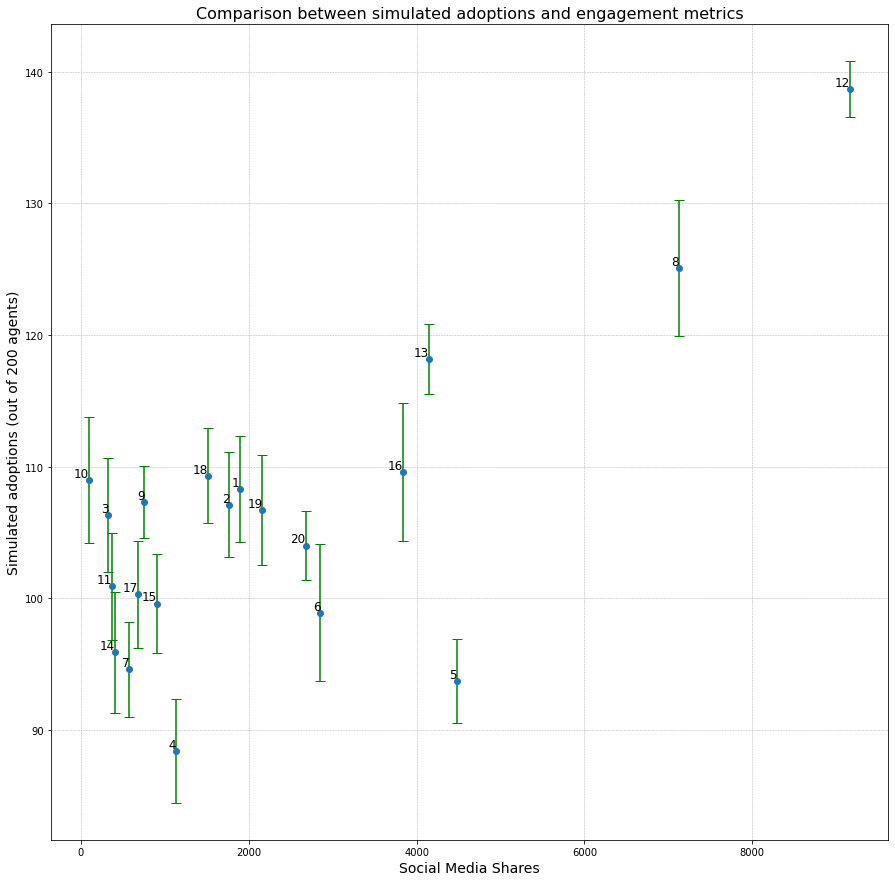

In [41]:
summary = last.groupby(["Trial","story_item"])["adopted"].sum().reset_index()
final = summary.groupby(['story_item'])['adopted'].agg(
    Mean='mean',
    SEM=lambda x: np.std(x, ddof=1) / np.sqrt(x.count())).reset_index()
    
merged = df.merge(final,left_on="Item",right_on="story_item")
x = merged.Shares.to_list()
y = merged.Mean.to_list()
plt.figure(figsize=[15,15])
#plt.scatter(x,y)
plt.errorbar(x, y, yerr=merged.SEM, fmt='o', ecolor='green', capsize=5, label='Data points')

for i, label in enumerate(merged.story_item.to_list()):
    plt.text(x[i],y[i],f"{int(label)}",fontsize=12,ha='right',va='bottom')
plt.xlabel("Social Media Shares",fontsize=14)
plt.ylabel("Simulated adoptions (out of 200 agents)",fontsize=14)
plt.title("Comparison between simulated adoptions and engagement metrics",fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding gridlines with custom style



plt.show()

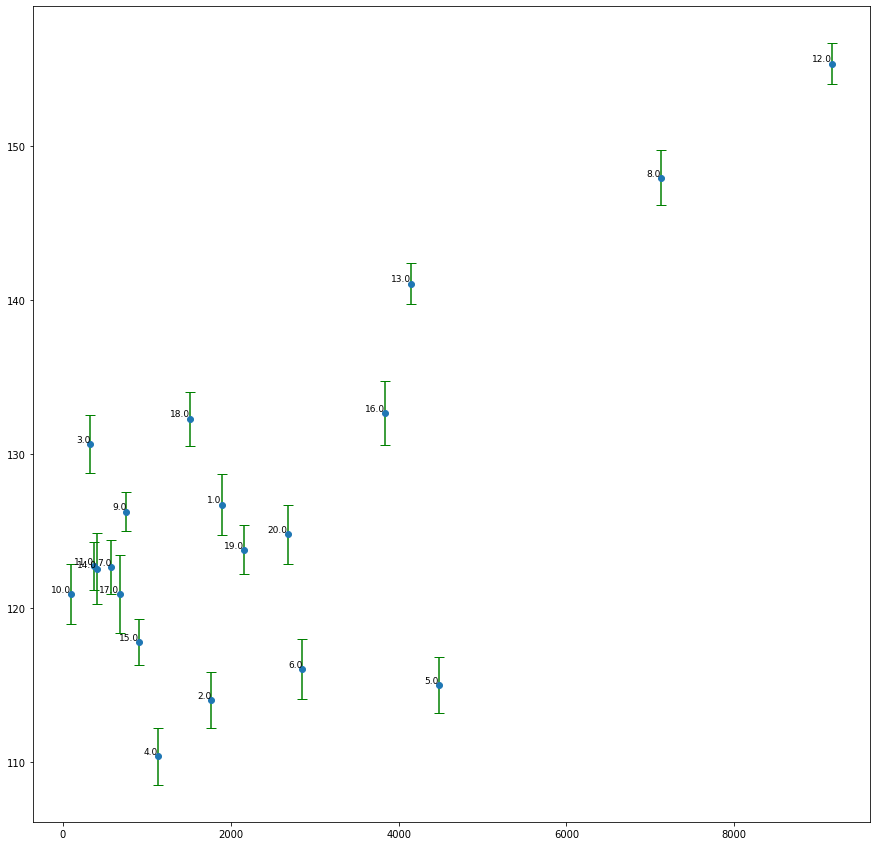

In [30]:
summary = last.groupby(["Trial","story_item"])["adopted"].sum().reset_index()
final = summary.groupby(['story_item'])['adopted'].agg(
    Mean='mean',
    SEM=lambda x: np.std(x, ddof=1) / np.sqrt(x.count())).reset_index()
    
merged = df.merge(final,left_on="Item",right_on="story_item")
x = merged.Shares.to_list()
y = merged.Mean.to_list()
plt.figure(figsize=[15,15])
#plt.scatter(x,y)
plt.errorbar(x, y, yerr=merged.SEM, fmt='o', ecolor='green', capsize=5, label='Data points')

for i, label in enumerate(merged.story_item.to_list()):
    plt.text(x[i],y[i],f"{label}",fontsize=9,ha='right',va='bottom')

plt.show()